##### Data Source : http://idd.insaan.iiit.ac.in/dataset/download/

#### Install Packages

In [ ]:
!pip install tensorflow==2.1
!pip install -U segmentation-models

In [ ]:
!tar -xvf /content/drive/MyDrive/idd-20k-II.tar.gz                              # uncompress dataset

#### Import Packages

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import math 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 
from PIL import ImagePath 
from  tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import cv2
import imgaug.augmenters as iaa
import tensorflow as tf
import shutil 
import random
import urllib.request

# semantic segmentation model packages
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score

In [ ]:
def dir_to_df(root_dir_image, root_dir_json) :

    '''
    Input :
        name    : root_dir_image
        type    : str
        content : uncompressed images folder path

        name    : root_dir_json
        type    : str
        content : uncompressed json folder path


    Output :
        name    : df
        type    : pandas dataframe
        content : dataframe contains image and json file paths


    Process :
        This function takes image and json file dir path 
        and store all image and json file path in dataframe.

    '''

    # store image path
    image_path = [ ]
    for root, dir, files in sorted(os.walk(root_dir_image)) : 
        for content in sorted(files) :
            image_path.append(str(root) + "/" + str(content))


    # store json path
    json_path = [ ]
    for root, dir, files in sorted(os.walk(root_dir_json)) : 
        for content in sorted(files) :
            json_path.append(str(root) + "/" + str(content))


    
    # image path dataset
    img_df = pd.DataFrame(image_path, columns=['images'])
    # add folder name
    img_df['image_dir'] = img_df['images'].str.split("/").str[4]
    # keep only train and val images
    img_df = img_df[img_df.image_dir != "test"]


    # json path dataset
    jsn_df = pd.DataFrame(json_path, columns=['json'])
    # add folder name
    jsn_df['json_dir'] = jsn_df['json'].str.split("/").str[4]

    df = pd.concat([img_df.reset_index(drop=True), jsn_df], axis=1)

    return df

In [ ]:
df = dir_to_df("/content/idd20kII/leftImg8bit", "/content/idd20kII/gtFine")     # create path dataframe

In [ ]:
df

,images,image_dir,json,json_dir
0,/content/idd20kII/leftImg8bit/train/201/frame0...,train,/content/idd20kII/gtFine/train/201/frame0029_g...,train
1,/content/idd20kII/leftImg8bit/train/201/frame0...,train,/content/idd20kII/gtFine/train/201/frame0299_g...,train
2,/content/idd20kII/leftImg8bit/train/201/frame0...,train,/content/idd20kII/gtFine/train/201/frame0779_g...,train
3,/content/idd20kII/leftImg8bit/train/201/frame1...,train,/content/idd20kII/gtFine/train/201/frame1019_g...,train
4,/content/idd20kII/leftImg8bit/train/201/frame1...,train,/content/idd20kII/gtFine/train/201/frame1469_g...,train
...,...,...,...,...
8084,/content/idd20kII/leftImg8bit/val/580/frame809...,val,/content/idd20kII/gtFine/val/580/frame8095_gtF...,val
8085,/content/idd20kII/leftImg8bit/val/580/frame878...,val,/content/idd20kII/gtFine/val/580/frame8785_gtF...,val
8086,/content/idd20kII/leftImg8bit/val/580/frame914...,val,/content/idd20kII/gtFine/val/580/frame9145_gtF...,val
8087,/content/idd20kII/leftImg8bit/val/580/frame962...,val,/content/idd20kII/gtFine/val/580/frame9625_gtF...,val


In [ ]:
df.shape

(8089, 4)

In [ ]:
def label_extract(data_df) :

    '''
    Input :
        name    : data_df
        type    : pandas dataframe
        content : pandas dataframe contains image path and json path columns

    Output :
        name    : unique_labels
        type    : numpy.array
        content : unique labels (array of strings)

    Process :
        This function takes image and json file dir path as dataframe
        and extract json files based on json file path and extract 
        label and store into list and get unique list.

    '''


    unique_labels = [ ]

    # extract json file path
    for file in tqdm(data_df['json']) :

        # open file
        f = open(file, mode="r")
        data = json.load(f)

        # extract objects and store labels
        for dictt in data['objects'] :
            unique_labels.append(dictt['label'])

    # get unique labels
    return np.unique(unique_labels)

In [ ]:
unique_labels = label_extract(df)                                               # get unique labels
unique_labels.shape

  0%|          | 0/8089 [00:00<?, ?it/s]

(41,)

In [ ]:
unique_labels                                                                   # unique labels list

array(['animal', 'autorickshaw', 'bicycle', 'billboard', 'bridge',
       'building', 'bus', 'car', 'caravan', 'curb', 'drivable fallback',
       'ego vehicle', 'fallback background', 'fence', 'ground',
       'guard rail', 'license plate', 'motorcycle',
       'non-drivable fallback', 'obs-str-bar-fallback', 'out of roi',
       'parking', 'person', 'pole', 'polegroup', 'rail track',
       'rectification border', 'rider', 'road', 'sidewalk', 'sky',
       'traffic light', 'traffic sign', 'trailer', 'train', 'truck',
       'tunnel', 'unlabeled', 'vegetation', 'vehicle fallback', 'wall'],
      dtype='<U21')

In [ ]:
# {label name : values}
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200, 'license plate' : 210}

len(label_clr)

41

In [ ]:
def get_poly(file) :

    '''
    Input :
        name    : file
        type    : JSON file
        content : image infomation in json format

    Output :
        name    : width, height, label_list, polygon_list
        type    : int, int, str, list
        content : different parameters for image

    Process :
        This function takes json file and extract width, height
        label and vertex for the image objects.

    '''

    # load image file
    file = open(file, "r")
    load_file = json.loads(file.read())

    # extract height and width
    height = load_file['imgHeight']
    width  = load_file['imgWidth']

    label_list = [ ]
    polygon_list = [ ]

    # extract objects dict
    for obt in load_file['objects'] :

        # get vertex
        vertex = [tuple(i) for i in obt['polygon']]

        label_list.append(obt['label'])
        polygon_list.append(vertex)

    return width, height, label_list, polygon_list
    

In [ ]:
json_file = df['json'].values[0]
print("Json file name :", json_file)
# json file sample output
width, height, label_list, polygon_list = get_poly(json_file)

print("w :", width, "h :", height)
print("label list :", label_list)
print("polygon list :", polygon_list)

Json file name : /content/idd20kII/gtFine/train/201/frame0029_gtFine_polygons.json
w : 1920 h : 1080
label list : ['road', 'drivable fallback', 'drivable fallback', 'drivable fallback', 'drivable fallback', 'motorcycle', 'sky', 'drivable fallback', 'curb', 'motorcycle', 'motorcycle', 'building', 'vegetation', 'vegetation', 'obs-str-bar-fallback', 'billboard', 'vegetation', 'building', 'obs-str-bar-fallback', 'building', 'building', 'obs-str-bar-fallback', 'building', 'autorickshaw', 'billboard', 'billboard', 'obs-str-bar-fallback', 'pole', 'obs-str-bar-fallback', 'car', 'building', 'obs-str-bar-fallback', 'truck', 'person', 'person', 'building', 'building', 'pole', 'building', 'pole', 'obs-str-bar-fallback', 'obs-str-bar-fallback', 'building', 'pole', 'building', 'billboard', 'billboard', 'billboard', 'pole', 'billboard', 'billboard', 'billboard', 'obs-str-bar-fallback', 'obs-str-bar-fallback', 'person', 'motorcycle', 'car', 'obs-str-bar-fallback', 'motorcycle', 'truck', 'motorcycle', 

In [ ]:
def create_mask_image(data_df) :
    

    '''

    Input :
        name    : data_df
        type    : pandas dataframe
        content : pandas dataframe contains image and json file path

    Output :
        name    : data_df
        type    : pandas dataframe
        content : modified dataframe image, json and mask image path

    Process :
        This function takes path dataframe and generate mask image based on
        json file and different fuction and store mask image and return path into
        pandas dataframe.

    '''

    mask_path = [ ]
    rows = [ ]  

    #  extract json file
    for path in tqdm(data_df['json'].values) :

        # replace output string into mask string
        new_path = path.replace("mask", "output")
        # for the path json replace with png
        new_path = new_path.replace("json", "png")

        # get image infomation, width, height, label and cordinate
        w, h, label, cordinate = get_poly(path)
        img  = Image.new("RGB", (w,h))
        img1 = ImageDraw.Draw(img)

        # fill up cordinate using polygon method
        for label, cor in zip(label, cordinate) :

            try :
                img1.polygon(cor, fill=label_clr[label]) 
            except :
                pass

        # create new dir
        os.makedirs(os.path.dirname(new_path), exist_ok=True)

        # convert image into array
        image = np.array(img)
        # append image path
        mask_path.append(new_path)
        # write image
        cv2.imwrite(new_path, image)

    # add mask column
    data_df['mask'] = mask_path


    return data_df

In [ ]:
df2 = create_mask_image(df)                 # create mask images

  0%|          | 0/8089 [00:00<?, ?it/s]

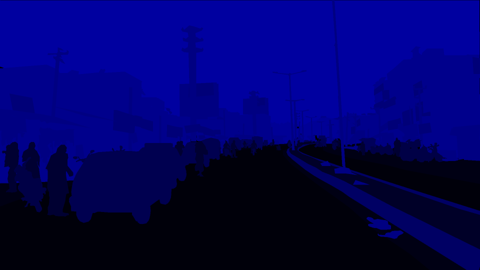

In [ ]:
# plot random mask image
img = Image.open(df2['mask'].values[0])
img.thumbnail((480,480))
img

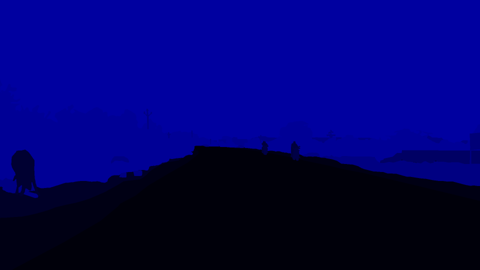

In [ ]:
# plot random mask image
img = Image.open(df2['mask'].values[10])
img.thumbnail((480,480))
img

In [ ]:
tf.keras.backend.clear_session()
os.environ["SM_FRAMEWORK"] = "tf.keras"
tf.keras.backend.set_image_data_format('channels_last')                         # set default image format as last channel

# loading the unet model and using the resnet 50 and initialized weights with Imagenet weights.
# "classes" : different types of classes in the dataset.
backbone = 'resnet50'
preprocess_input = sm.get_preprocessing(backbone)

Segmentation Models: using `tf.keras` framework.


In [ ]:
# This function is used to visualize the images and it's respective mask.
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# Creating the Batch Dataset for the model.
class Dataset:
    # we will be modifying this CLASSES according to the data/problems
    CLASSES = [0,1,2,3,4,5,6,7,8,9
               ,10,11,12,13,14,15,16,17,18,19,20]
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes = None):
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
        mask = mask / 10
        #image_mask = normalize_image(mask)

        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
               
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
df2.drop(['image_dir', "json_dir"], inplace=True, axis=1)

In [ ]:
train, val = train_test_split(df2, test_size = 0.2)                             # split data for training and testing
train.shape, val.shape

((6471, 5), (1618, 5))

In [ ]:
train

,images,image_dir,json,json_dir,mask
4197,/content/idd20kII/leftImg8bit/train/439/frame2...,train,/content/idd20kII/gtFine/train/439/frame28362_...,train,/content/idd20kII/gtFine/train/439/frame28362_...
1586,/content/idd20kII/leftImg8bit/train/283/frame4...,train,/content/idd20kII/gtFine/train/283/frame4905_g...,train,/content/idd20kII/gtFine/train/283/frame4905_g...
2947,/content/idd20kII/leftImg8bit/train/371/frame2...,train,/content/idd20kII/gtFine/train/371/frame20899_...,train,/content/idd20kII/gtFine/train/371/frame20899_...
2527,/content/idd20kII/leftImg8bit/train/340/frame1...,train,/content/idd20kII/gtFine/train/340/frame1064_g...,train,/content/idd20kII/gtFine/train/340/frame1064_g...
5383,/content/idd20kII/leftImg8bit/train/483/frame1...,train,/content/idd20kII/gtFine/train/483/frame12693_...,train,/content/idd20kII/gtFine/train/483/frame12693_...
...,...,...,...,...,...
5204,/content/idd20kII/leftImg8bit/train/472/frame1...,train,/content/idd20kII/gtFine/train/472/frame1629_g...,train,/content/idd20kII/gtFine/train/472/frame1629_g...
7415,/content/idd20kII/leftImg8bit/val/379/frame586...,val,/content/idd20kII/gtFine/val/379/frame58679_gt...,val,/content/idd20kII/gtFine/val/379/frame58679_gt...
7994,/content/idd20kII/leftImg8bit/val/518/0014085_...,val,/content/idd20kII/gtFine/val/518/0014085_gtFin...,val,/content/idd20kII/gtFine/val/518/0014085_gtFin...
7118,/content/idd20kII/leftImg8bit/val/274/frame026...,val,/content/idd20kII/gtFine/val/274/frame0269_gtF...,val,/content/idd20kII/gtFine/val/274/frame0269_gtF...


In [ ]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]            # classes
BATCH_SIZE = 8                                                                                  # batch size
img_size = (256, 256, 3)                                                                        # image size
n_classes = len(CLASSES)                                                                        # len of classes

In [ ]:
train_dataset = Dataset(train, classes=CLASSES)                                 # preprocess data for training
val_dataset  = Dataset(val, classes=CLASSES)                                    # preprocess data for testing

# set up data for model training and testing
train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(8, 256, 256, 3)
(8, 256, 256, 3, 21)


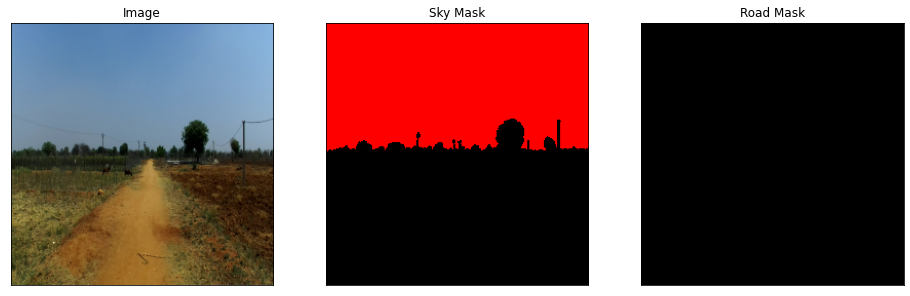

In [ ]:
img, mas = train_dataset[51]
visualize(image = img, sky_mask = mas[:, :, :, 16], road_mask = mas[:, :, :, 1])

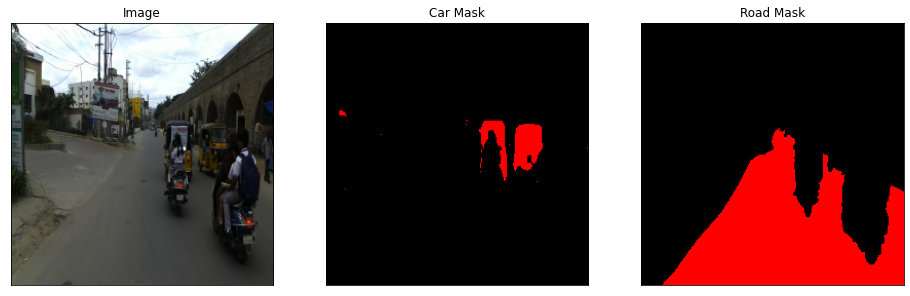

In [ ]:
img, mas = train_dataset[151]
visualize(image = img, car_mask = mas[:, :, :, 8], road_mask = mas[:, :, :, 1])

In [ ]:
tf.keras.backend.clear_session()
# load UNET Model
model = Unet(backbone_name = backbone, input_shape = img_size, classes = n_classes, activation = 'softmax', encoder_freeze = True,
             encoder_weights = 'imagenet', decoder_block_type = 'upsampling')

94592056/94592056 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

In [ ]:
# Dice loss
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only = True, save_best_only = True,
                                       mode = 'max', monitor = 'val_iou_score', verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', patience = 1, mode = 'max', verbose = 1),
]

In [ ]:
train_steps = train.shape[0]//BATCH_SIZE            # set up batch size training
valid_steps = val.shape[0]//BATCH_SIZE              # set up batch size training
len(train_dataloader), train_steps

(808, 808)

In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch = train_steps, epochs = 50,\
                              validation_data = val_dataloader, validation_steps = valid_steps,
                              callbacks = callbacks)

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 0.9334 - iou_score: 0.1015
Epoch 00001: val_iou_score improved from -inf to 0.13969, saving model to ./best_model.h5
400/400 [==============================] - 345s 863ms/step - loss: 0.9334 - iou_score: 0.1015 - val_loss: 0.8684 - val_iou_score: 0.1397
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.7964 - iou_score: 0.1919
Epoch 00002: val_iou_score improved from 0.13969 to 0.21779, saving model to ./best_model.h5
400/400 [==============================] - 347s 869ms/step - loss: 0.7964 - iou_score: 0.1919 - val_loss: 0.7666 - val_iou_score: 0.2178
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.7297 - iou_score: 0.2430
Epoch 00003: val_iou_score improved from 0.21779 to 0.25869, saving model to ./best_model.h5
400/400 [==============================] - 350s 874ms/step - loss: 0.7297 - iou_score: 0.2430 - val_loss: 0.7096 - val_iou_score: 0.2587
Epoch 4/50
400/400 [==

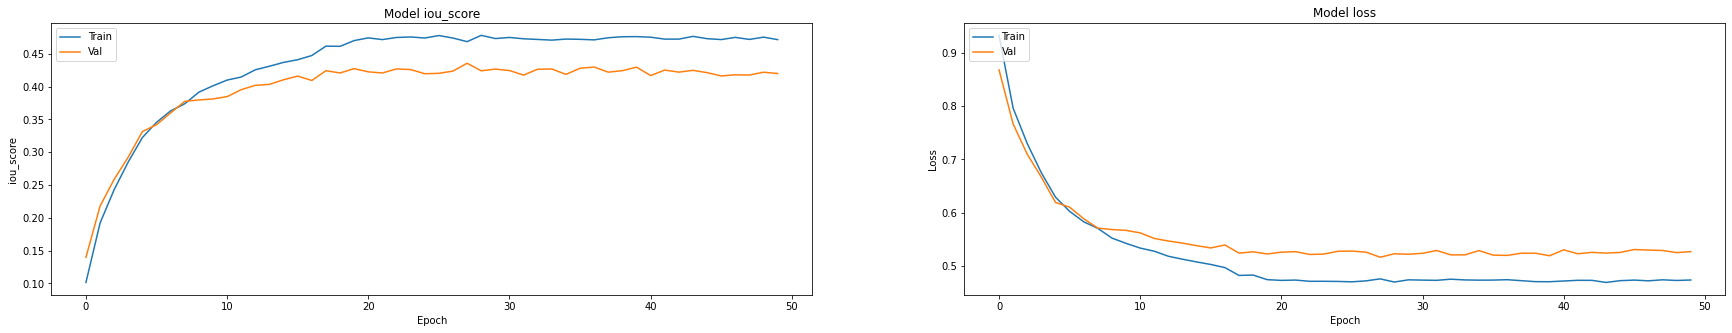

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
images_ = val['images'].values
masks_ = val['mask'].values
lst = np.arange(len(images_))

#### Prediction on Random Images

1/1 [==============================] - 0s 5ms/step


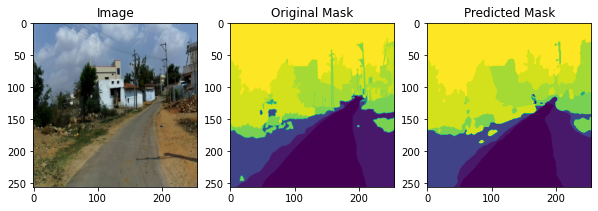

1/1 [==============================] - 0s 9ms/step


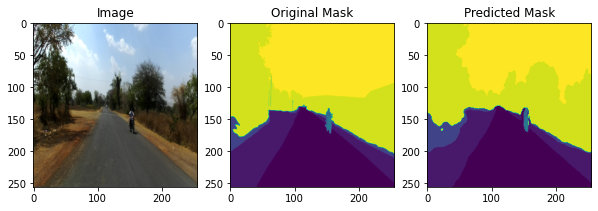

1/1 [==============================] - 0s 9ms/step


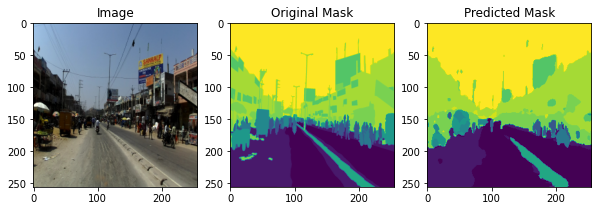

1/1 [==============================] - 0s 9ms/step


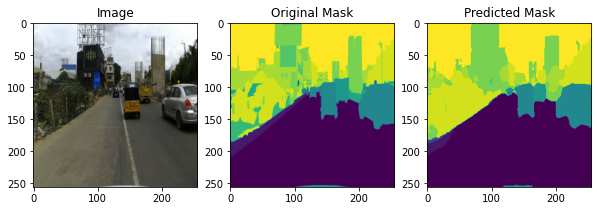

1/1 [==============================] - 0s 19ms/step


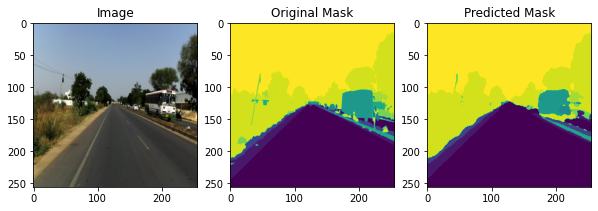

1/1 [==============================] - 0s 19ms/step


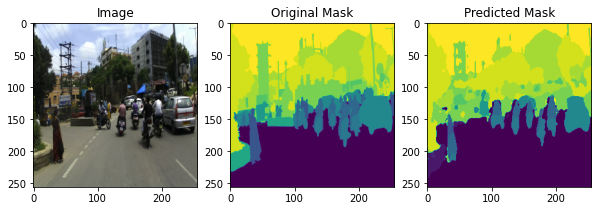

1/1 [==============================] - 0s 19ms/step


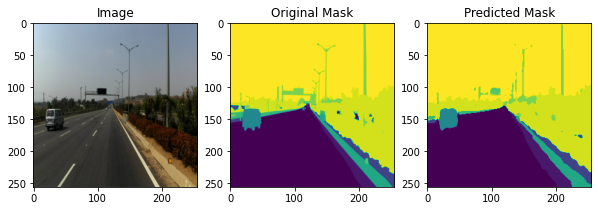

1/1 [==============================] - 0s 19ms/step


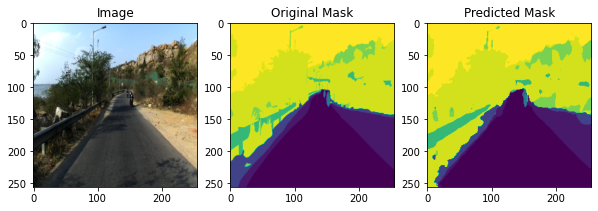

1/1 [==============================] - 0s 20ms/step


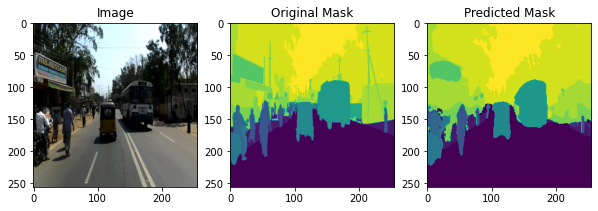

1/1 [==============================] - 0s 19ms/step


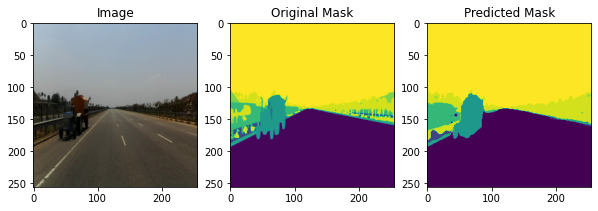

1/1 [==============================] - 0s 19ms/step


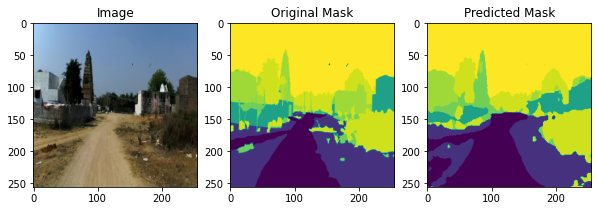

1/1 [==============================] - 0s 19ms/step


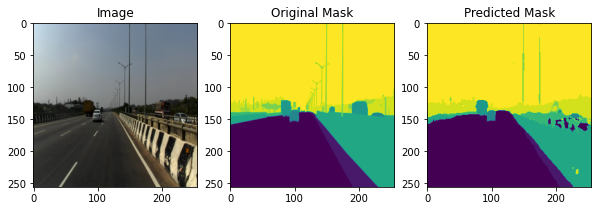

1/1 [==============================] - 0s 19ms/step


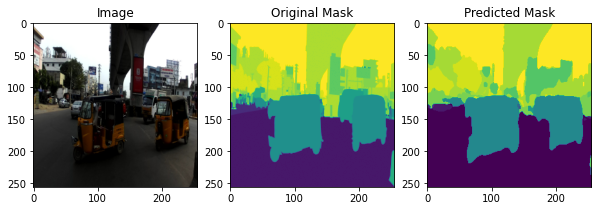

1/1 [==============================] - 0s 19ms/step


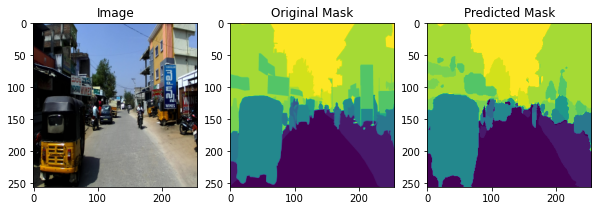

1/1 [==============================] - 0s 18ms/step


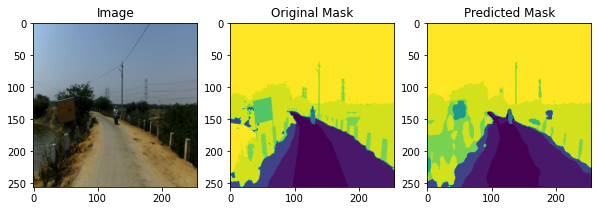

In [ ]:
# Visualizing the predicted mask for val data.
import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.expand_dims(image, axis=0)

  mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
  mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
  mask = mask / 10
  pred = model.predict(image,verbose=1)
  pred = tf.argmax(pred, axis=-1)

  fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(131)
  ax1.imshow(image[0,:,:])
  ax2=fig.add_subplot(132)
  ax2.imshow(mask)
  ax3=fig.add_subplot(133)
  ax3.imshow(pred[0,:,:])
  ax1.title.set_text('Image')
  ax2.title.set_text('Original Mask')
  ax3.title.set_text('Predicted Mask')
  plt.show()